In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from utils import create_model, prepare_datasets, getHeatMap
from config import config
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-09-08 13:45:18.580986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 13:45:19.140370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Quantitative Results

In [2]:
model_filename = "DenseNet121_20230908_101349_E100_LR0.0001_DR0.5"
history = pd.read_csv(f"runs/{model_filename}.csv")

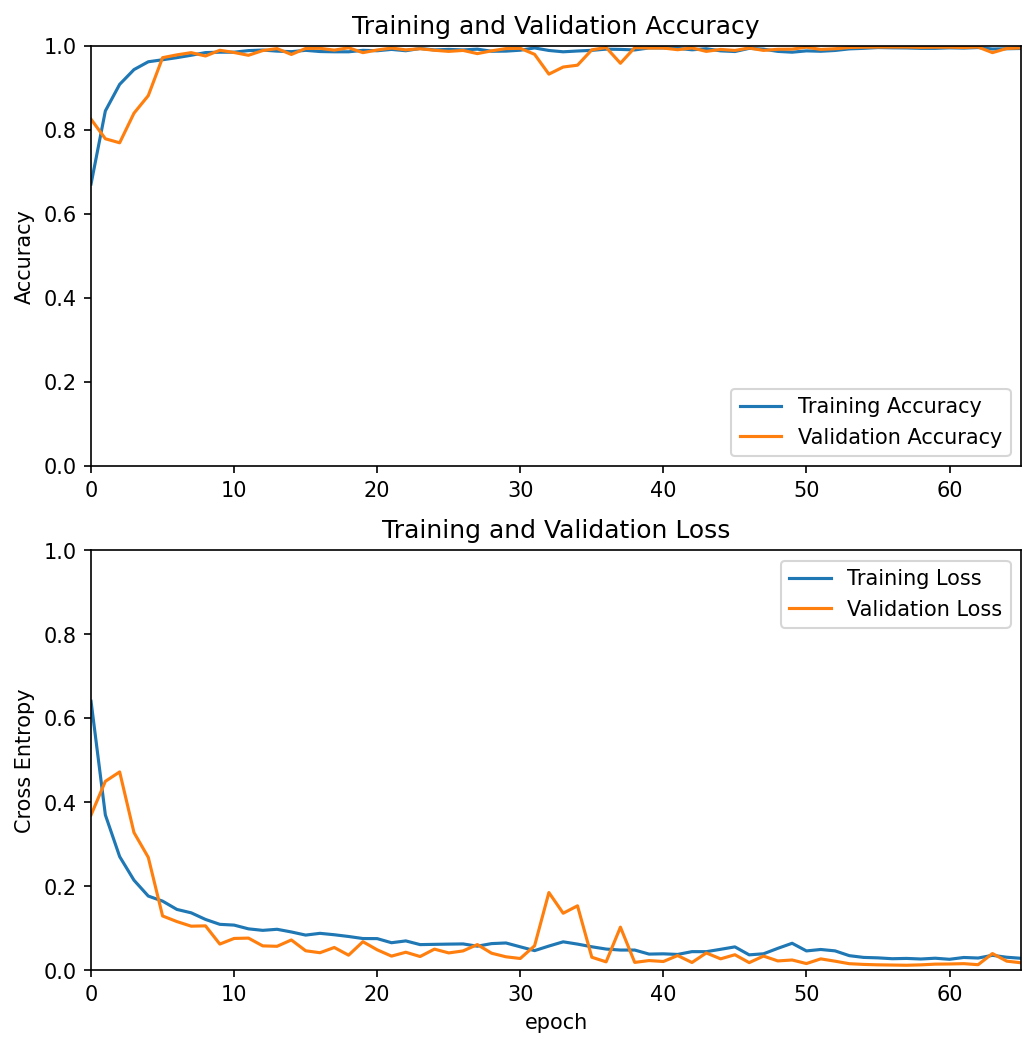

In [3]:
acc = history["accuracy"]
val_acc = history["val_accuracy"]

loss = history["loss"]
val_loss = history["val_loss"]

plt.figure(figsize=(8, 8), dpi=150)
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.xlim([0, len(history["accuracy"]) - 1])
plt.ylim([0, 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.xlim([0, len(history["accuracy"]) - 1])
plt.ylim([0, 1])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [4]:
_, _, test_set = prepare_datasets("cropped_dataset", config)
test_labels = np.concatenate([y for x, y in test_set], axis=0)
test_labels = list(test_labels.flatten().astype("uint8"))

Found 4514 files belonging to 2 classes.


Using 3160 files for training.
Found 4514 files belonging to 2 classes.
Using 3009 files for validation.
Found 4514 files belonging to 2 classes.


2023-09-08 13:45:21.145441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13638 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


Using 1504 files for validation.


In [5]:
base_model = tf.keras.applications.DenseNet121(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling=None
)

model = create_model(base_model, config)
checkpoint_dir = f"checkpoints/{model_filename}"
latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(latest_ckpt)

In [6]:
y_pred = model.predict(test_set)

2023-09-08 13:45:27.585454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-08 13:45:28.049288: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-08 13:45:28.147413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


47/47 [==============================] - 5s 45ms/step


In [7]:
y_pred = y_pred.flatten()
y_pred = list(tf.where(y_pred < 0.5, 0, 1).numpy())

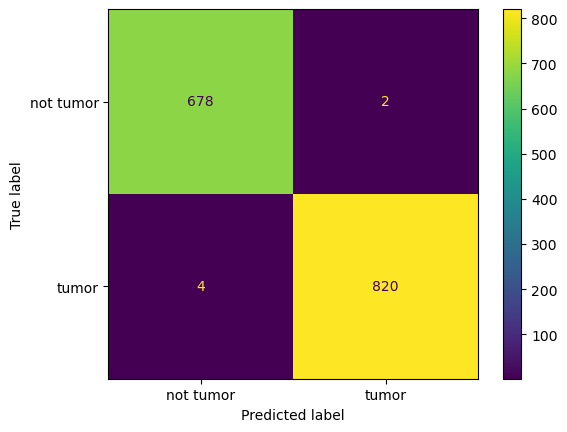

In [8]:
class_names = ["not tumor", "tumor"]

cm = confusion_matrix(y_true=test_labels, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [9]:
image_batch, label_batch = test_set.as_numpy_iterator().next()
images = np.copy(image_batch)
images = images / 255
labels = list(label_batch.flatten().astype(np.uint8))

gradcam_heatmaps = getHeatMap(model.get_layer("densenet121"), images, labels)

In [14]:
plt.figure(figsize=(15, 15), dpi=600)

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.imshow(gradcam_heatmaps[i], cmap="jet", alpha=0.4)

    misclassified = (
        class_names[y_pred[i].astype("uint8")]
        == class_names[label_batch[i][0].astype("uint8")]
    )

    color = "black" if misclassified else "red"
    plt.title(
        f"pred: {class_names[y_pred[i].astype('uint8')]}\n true: {class_names[label_batch[i][0].astype('uint8')]}",
        color=color,
        fontsize=16,
    )
    plt.axis("off")

plt.tight_layout()
plt.show()